# LM7805 Analysis and Simulation

By Shuo Chen (chenshuo_at_chenshuo.com)

Latest notebook: https://github.com/chenshuo/notes/blob/master/notebooks/LM7805.ipynb

Comments and discussions: https://github.com/chenshuo/notes/discussions

Series of analysis & simulation of IC regulator designed in 1970s:

1. [μA78L05](https://chenshuo.github.io/notes/UA78L05)
2. [LM7805](https://chenshuo.github.io/notes/LM7805) <- This page
3. [TL431](https://chenshuo.github.io/notes/TL431)

In [1]:
%matplotlib inline

from math import exp, log, log10

# NgSpice
import ngspyce as ng

import numpy as np
from matplotlib import pyplot as plt

def para(r1, r2):
    return (r1*r2) / (r1 + r2)

def print_op(print_base_current=True, print_emitter_current=False):
  op = ng.operating_point()
  for k in sorted(op.keys()):
    if k[0] == '@' or '#branch' in k:
        if '[is]' in k:
            continue
        if '[ib]' in k and not print_base_current:
            continue
        if '[ie]' in k and not print_emitter_current:
            continue

        print('%10s = %8.2f uA' % (k, 1e6*op[k][0]))
    else:
        print('%10s = %8.2f mV' % (k, 1e3*op[k][0]))

In [2]:
# Circuitikz
# pip install git+https://github.com/mkrphys/ipython-tikzmagic.git

%load_ext tikzmagic

## LM7805 != μA7805

https://www.righto.com/2014/09/reverse-engineering-counterfeit-7805.html

In most if not all practices, LM7805 and μA7805 can be used interchangeablly, but their internal schematic are different.
[Ken Shirriff suspects](https://www.righto.com/2014/09/reverse-engineering-counterfeit-7805.html) "manufacturers are constrained by patents, so they use the part numbers they want on the devices they can make."

Two common designs:
1. LM7805 $=$ LM340 from National semiconductor. based on [LM109/LM309](https://www.ti.com/lit/an/snva512b/snva512b.pdf) by Robert Widlar in 1969.
2. μA7805 from Fairchild semiconductor, debut in 1971.

The obvious difference is their reference voltage, μA7805 has 4 $V_\mathrm{BE}$ on its reference voltage, after temperature compensation $V_\mathrm{REF} \approx 4 \times V_\mathrm{g0}\approx 4.8$V.
While LM7805 has 3 $V_\mathrm{BE}$ on its reference voltage, so after temperature compensation $V_\mathrm{REF} \approx 3 \times V_\mathrm{g0}\approx 3.6$V.

### LM7805

Alias of [LM340](https://www.ti.com/lit/ds/symlink/lm340.pdf).

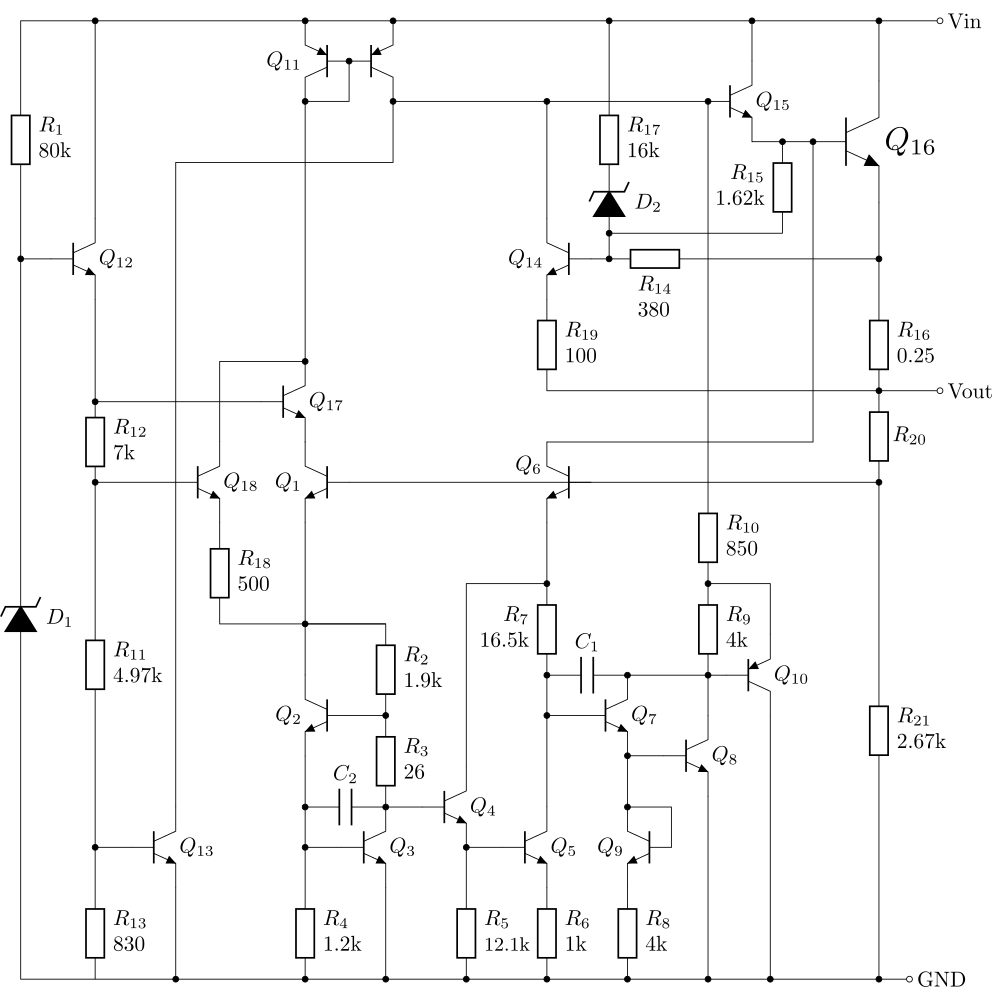

> This is a vector graphic, right click and open it in a new tab, then zoom in as you need.

### μA7805

The [current TI datasheet](https://www.ti.com/lit/ds/symlink/ua78.pdf) doesn't specify resistor values,
check 1971 Fairchild [Linear Integrated Circuits Data Catalog](https://bitsavers.org/components/fairchild/_dataBooks/1971_Fairchild_Linear_Integrated_Circuits_Data_Catalog.pdf) instead.

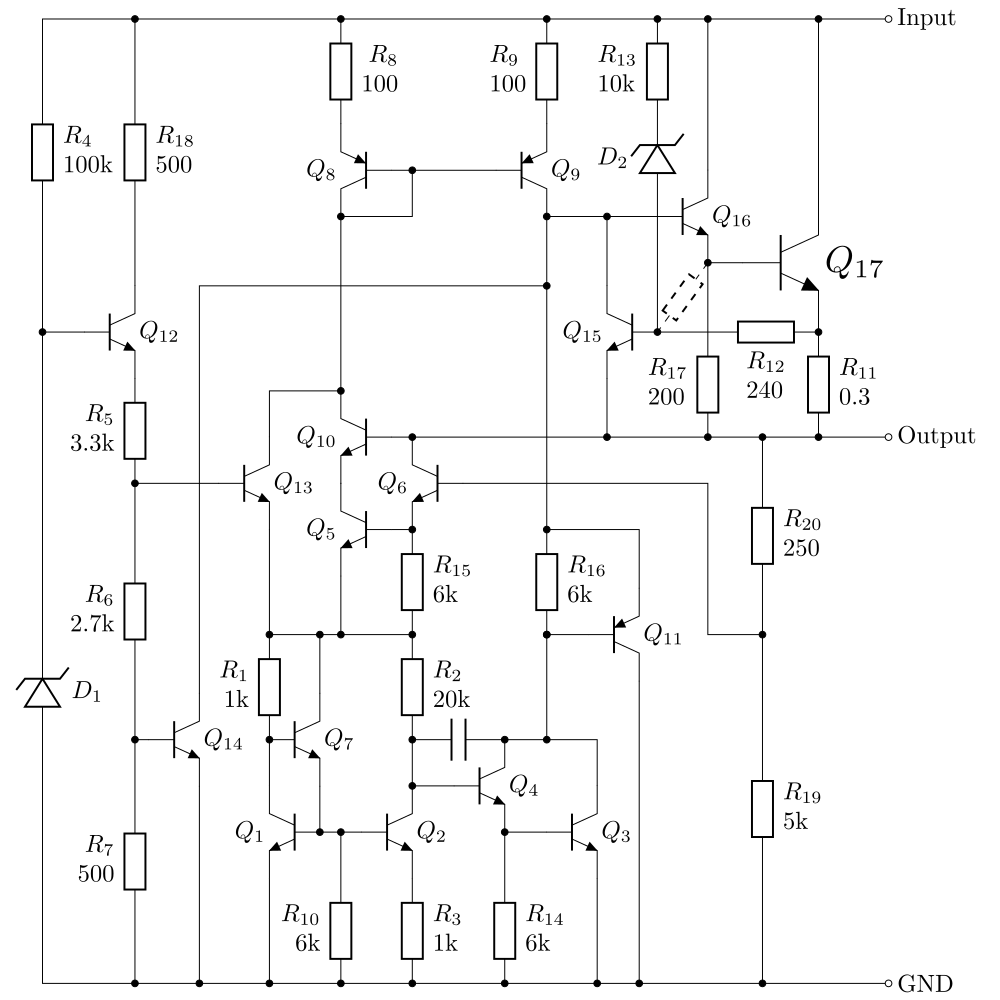

A few notes:

1. Unlabelled $R_{21}$ between base of $Q_{15}$ and emitter of $Q_{16}$ didn't exist in 1971 or 1973 datasheets from Fairchild. So it's drawn in dashed lines.
2. Value of $R_{16}$ changes between 2kΩ and 6kΩ in different versions of datasheets, the value probably doesn't matter too much though.
3. $R_{20}=250$Ω is for 5V output, from this we can estimate the interal reference voltage at base of $Q_6$ is $\dfrac{5}{5+0.25}\times 5.0 = 4.762$V.
4. $Q_{16}$ and $Q_{17}$ is Darlinton pair, as the output stage, a.k.a. series pass transistors.
5. $Q_{15}$ and current sense resistor $R_{11}$ limits the output current.  When in normal operation, $Q_{15}$ is off.
6. Zener diode $D_2$ and $Q_{15}$ prevent overvoltage break down of output pass transistors. (It's called "Output Transistor Safe-Area Compensation" in the datasheet.)
7. Zener diode $D_1$ and $Q_{14}$ provides overheat protection (called "Thermal-Overload Protection" in the datasheet). When in normal operation, $Q_{14}$ is off.
8. Zener diode $D_1$ and $Q_{12}$/$Q_{13}$ is startup circuit, provide initial bias for $Q_1, Q_7, Q_8$ when power up. When in normal operation, $Q_{13}$ is off.
9. The rest transistors $Q_1 \dots Q_{11}$ are the core function of voltage reference, error amplifier ($Q_4$, $Q_3$ and $Q_{11}$), current mirror ($Q_8$ and $Q_9$) as active load, etc.

## μA7805

### Simplified schematic

Adapted from 1974 Fairchild [_Voltage Regulator Applications Handbook_](https://bitsavers.org/components/fairchild/_dataBooks/1974_Fairchild_Voltage_Regulator_Applications_Handbook.pdf), p.2-4


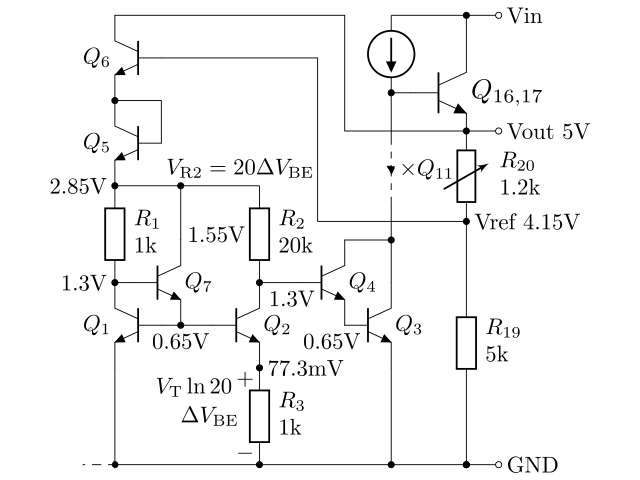

Brief analysis:

The main part of the bandgap reference: $Q_1$, $Q_2$ generates $\Delta V_\mathrm{BE}$ on $R_3$, and magnify it on $R_2$.
$R_2$ is critical, as the voltage on it $V_\mathrm{R2}$ has  positive tempco, to cancel negative tempco of 4 $V_\mathrm{BE}$s.

7805 works in a different way than [μA78L05](https://chenshuo.github.io/notes/UA78L05), the latter is traditional: generating stable reference voltage usng bandgap circuit, then comparing output voltage against it.

In 7805, the bandgap reference works ["backwards"](https://www.righto.com/2014/09/reverse-engineering-counterfeit-7805.html), the whole chip can be viewed as a bandgap reference.
The "purpose" of the circuit, including its external load, is maintaining a stable voltage at the base of $Q_6$, which according to literature, it is supposed to be 4.8V, that is $4 \times V_\mathrm{g0}$.
What we really want from this circuit, is its "side-effect" of delivering stable 5V voltage output at Vout pin.
In other words, the error amplifier made of $Q_3, Q_4, \mathrm{and} Q_{11}$, and the output pass transistors $Q_{16}$ and $Q_{17}$ are all part of the feedback look of the bandgap reference, whose error singal is from collector of $Q_2$.

$Q_4$ and $Q_3$ form a Darlinton pair to amplify the voltage error. I guess the initial design consists $Q_1, Q_2, Q_3$ only, $Q_4$ was added later to increase the gain of error amplifier.
With the addition of $Q_4$, the voltage at collector of $Q_2$ increased to 2 $V_\mathrm{BE}$s, to compensate that, $Q_7$ was added to increase the voltage of Q1C to  2 $V_\mathrm{BE}$s as well.
Then $R_{10}$ was added (not shown in the simplified schematic) to provide a path for emitter current of $Q_7$ (~132μA).
The purpose was to keep the voltage drop on $R_1$ and $R_2$ the same, so that the current ratio on $Q_1$ and $Q_2$ is about $20:1$, 1420μA vs. 75μA.

Feedback loop:
1. $Q_6$ and $Q_5$ are emitter followers, $Q_4$ and $Q_3$ are error ampifier, those 4 transistors provides the negative tempco of voltage reference. Canceled by positive tempco on $V_\mathrm{R2}$
1. $Q_{11}$ (shown as dashed line in the simplified schematic) is a buffer, also a current amplifier, to minimize/reduce the current changes on $Q_4$ and $Q_3$, bacause $Q_4$ and $Q_3$ also serve as part of the bandgap voltage reference, we want their current stable.
1. Suppose load reduced, Vout ↑, Vref ↑, $V_\mathrm{Q6B}$↑, $V_\mathrm{Q5E}$↑, $V_\mathrm{Q4B}$↑, so the error voltage↑
1. $V_\mathrm{Q4B}$↑,  $I_\mathrm{C4}$ and $I_\mathrm{C3}$ ↑↑,  $I_\mathrm{E11}$ ↑↑↑, so $I_\mathrm{B16}$↓, (as $I_\mathrm{E11}+I_\mathrm{B16}+I_\mathrm{R16} = I_\mathrm{C9}$, and $I_\mathrm{C9}$ doesn't change much.)
1. $I_\mathrm{B16}$↓, $I_\mathrm{E16}$↓,  $I_\mathrm{B17}$↓,  $I_\mathrm{E17}$↓↓, Iout↓↓, finally Vout ↓.

Estimating quiescent operating point:

1. Assuming all $V_\mathrm{BE}\approx 0.65$V.
1. $V_\mathrm{Q1B} = V_\mathrm{Q3B} =0.65$V, $V_\mathrm{Q7B} = V_\mathrm{Q4B} =1.3$V
1. $V_\mathrm{R1} = V_\mathrm{R2}\ \Rightarrow\ I_\mathrm{R1} \cdot R_1 = I_\mathrm{R2} \cdot R_2$
1. $I_\mathrm{R1} = \dfrac{R_2}{R_1}I_\mathrm{R2} = 20 I_\mathrm{R2}$
1. $I_\mathrm{R1} \approx I_\mathrm{C1}$, $I_\mathrm{R2} \approx I_\mathrm{C2}$, so $I_\mathrm{C1} \approx 20 I_\mathrm{C2}$
1. $V_\mathrm{R3} = \Delta V_\mathrm{BE} = V_\mathrm{BE1} - V_\mathrm{BE2} = V_\mathrm{T} \ln \dfrac{I_\mathrm{C1}}{I_\mathrm{C2}}$
1. $\Delta V_\mathrm{BE} = V_\mathrm{T} \ln 20 \approx 3 V_\mathrm{T} = 77.3$mV
1. $V_\mathrm{R2} = \dfrac{R_2}{R_3} \Delta V_\mathrm{BE} = 20 \Delta V_\mathrm{BE} \approx 1.546$V
1. $V_\mathrm{Q5E} = V_\mathrm{R2} + V_\mathrm{Q4B} \approx 1.55 + 1.30 = 2.85$V
1. $V_\mathrm{REF} = V_\mathrm{Q6B} = V_\mathrm{Q5E} + V_\mathrm{BE5} + V_\mathrm{BE6} \approx  4.15$V


### SPICE model

I couldn't find a SPICE model, so I made my own for helping analysis.

```SPICE
  * UA7805 DC path model
  V1    vin  0   10V
  Rload out  0   100

  * Bandgap reference
  R1  q5e  q1c      1k
  Q1  q1c  q1b 0    NPN
  Q7  q5e  q1c q1b  NPN
  R10 q1b  0        6k
  Q2  q4b  q1b r3   NPN
  R3  r3   0        1k
  R2  q5e  q4b      20k

  * Error amplifier
  Q4  q11b q4b  q3b  NPN
  Q3  q11b q3b  0    NPN
  R14 q3b  0         6k
  Q11 0    q11b q9c  PNP
  R16 q9c  q11b      6k

  * Current mirror
  R8  vin  q8e 100
  R9  vin  q9e 100
  Q8  q8b  q8b q8e  PNP
  Q9  q9c  q8b q9e  PNP

  * Feedback
  Q10 q8b  out q10e NPN
  Q5  q10e q6e q5e  NPN
  Q6  out  ref q6e  NPN
  R15 q6e  q5e      6k
  R19 ref  0        5k
  R20 out  ref      1.25k

  * Output
  Q16 vin  q9c  q17b NPN
  Q17 vin  q17b q17e NPN 10
  R11 q17e out       0.3
  R17 q17b out       200

  * Start-up
  R4  vin  q12b      100k
  D1  0    q12b      DZ
  R18 vin  q12c      500
  Q12 q12c q12b q12e NPN
  R5  q12e q13b      3.3k
  R6  q13b q14b      2.7k
  R7  q14b 0         500
  Q13 q8b  q13b q5e  NPN
  
  .MODEL NPN NPN( IS=5f BF=80  VAF=100 CJC=1P CJE=2P )
  .MODEL PNP PNP( IS=2f BF=60  VAF=50  CJC=1P CJE=2P )
  .MODEL DZ D(BV=5.6)

* .options savecurrents
```

This model doesn't have output current limiting or over voltage protection circuits.

In [8]:
ng.circ('''
  V1    vin  0   10V
  Rload out  0   100

  * Bandgap reference
  R1  q5e  q1c      1k
  Q1  q1c  q1b 0    NPN
  Q7  q5e  q1c q1b  NPN
  R10 q1b  0        6k
  Q2  q4b  q1b r3   NPN
  R3  r3   0        1k
  R2  q5e  q4b      20k

  * Error amplifier
  Q4  q11b q4b  q3b  NPN
  Q3  q11b q3b  0    NPN
  R14 q3b  0         6k
  Q11 0    q11b q9c  PNP
  R16 q9c  q11b      6k

  * Current mirror
  R8  vin  q8e 100
  R9  vin  q9e 100
  Q8  q8b  q8b q8e  PNP
  Q9  q9c  q8b q9e  PNP

  * Feedback
  Q10 q8b  out q10e NPN
  Q5  q10e q6e q5e  NPN
  Q6  out  ref q6e  NPN
  R15 q6e  q5e      6k
  R19 ref  0        5k
  R20 out  ref      1.25k

  * Output
  Q16 vin  q9c  q17b NPN
  Q17 vin  q17b q17e NPN 10
  R11 q17e out       0.3
  R17 q17b out       200

  * Start-up
  R4  vin  q12b      100k
  D1  0    q12b      DZ
  R18 vin  q12c      500
  Q12 q12c q12b q12e NPN
  R5  q12e q13b      3.3k
  R6  q13b q14b      2.7k
  R7  q14b 0         500
  Q13 q8b  q13b q5e  NPN
  
  .options savecurrents
.MODEL NPN NPN( IS=5f BF=80  VAF=100 CJC=1P CJE=2P )
.MODEL PNP PNP( IS=2f BF=60  VAF=50  CJC=1P CJE=2P )
.MODEL DZ D(BV=5.6)
''')
op = print_op()

   @d1[id] =   -36.01 uA
  @q10[ib] =    17.75 uA
  @q10[ic] =  1478.53 uA
  @q11[ib] =   -18.81 uA
  @q11[ic] = -1258.61 uA
  @q12[ib] =     8.85 uA
  @q12[ic] =   737.29 uA
  @q13[ib] =    -0.00 uA
  @q13[ic] =     0.00 uA
  @q16[ib] =    50.07 uA
  @q16[ic] =  4146.83 uA
  @q17[ib] =   565.04 uA
  @q17[ic] = 47118.99 uA
   @q1[ib] =    17.64 uA
   @q1[ic] =  1420.20 uA
   @q2[ib] =     0.93 uA
   @q2[ic] =    75.08 uA
   @q3[ib] =     0.45 uA
   @q3[ic] =    38.27 uA
   @q4[ib] =     1.16 uA
   @q4[ic] =    97.18 uA
   @q5[ib] =    18.53 uA
   @q5[ic] =  1496.29 uA
   @q6[ib] =     1.62 uA
   @q6[ic] =   130.78 uA
   @q7[ib] =     1.61 uA
   @q7[ic] =   130.63 uA
   @q8[ib] =   -23.86 uA
   @q8[ic] = -1431.82 uA
   @q9[ib] =   -22.85 uA
   @q9[ic] = -1444.12 uA
   @r10[i] =   113.66 uA
   @r11[i] = 47684.03 uA
   @r14[i] =    97.89 uA
   @r15[i] =   113.87 uA
   @r16[i] =   116.64 uA
   @r17[i] =  3631.85 uA
   @r18[i] =   737.29 uA
   @r19[i] =   805.44 uA
    @r1[i] =  1421.81 uA


In [56]:
print('Bias current = %.2f mA' % (54.971 - 50.36))

Bias current = 4.61 mA


The following is the simulation result of DC operating point.

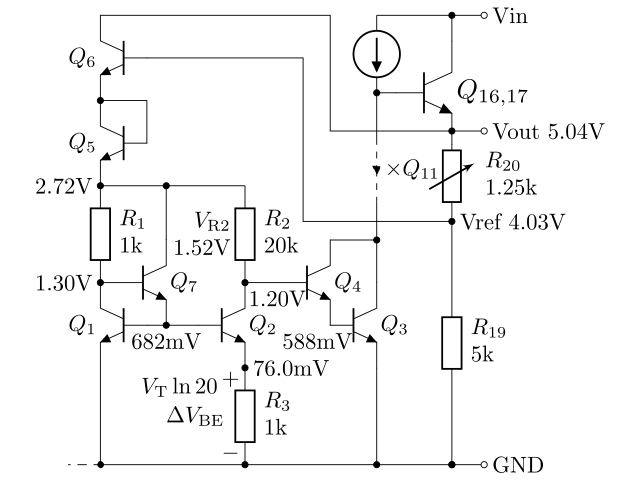

In [39]:
%%tikz -p circuitikz -s 640,480 -f svg
\newcommand{\uv}[1]{\ensuremath{V_\mathrm{#1}}}

\ctikzset{european resistors, american currents, american voltages, transistors/arrow pos=end, bipoles/length=1.2cm}
\usetikzlibrary {math}
\tikzmath{\x = 0.6;}

\draw (0, 0) coordinate(I)
  to [R, n=R2, l2={$R_2$ and 20k}, bipoles/length=1.0cm] ++(0, -1.5)
  node [npn, anchor=C] (Q2) {$Q_2$};
\draw (Q2.E) node [circ] {} node [right] {76.0mV}
  to [R, n=R3, l2={$R_3$ and 1k}, v={$\Delta\uv{BE}$}, bipoles/length=1.0cm] ++(0, -1.5)
  coordinate (G)
  node [circ] {};
\draw (Q2.B) to [short] ++(-0.8, 0)
  node [npn, anchor=B, xscale=-1] (Q1) {\ctikzflipx{$Q_1$}};
\draw (Q1.C) to [short, *-] ++(0.3, 0) node [npn, anchor=B] (Q7) {$Q_7$};
\draw (Q7.E) node [circ] {};
\draw (Q7.C) to [short, -*] (Q7.C|-I);

% \draw (Q1.C) to [R, l2_={$R_1$ and 1k}, bipoles/length=1.0cm] (Q1.C |- I) -- (I);
\draw (Q1.C|-I) to [R, l2={$R_1$ and 1k}, bipoles/length=1.0cm] ++(0, -1.5) -- (Q1.C);
\draw (Q1.C|-I) -- (I);
\draw (Q1.E) |- (G);
\draw [dashed] (Q1.E|-G) to [short, *-] ++(-0.5, 0);

\draw (Q2.C) to [short, *-] ++(0.6, 0)
  node [npn, anchor=B] (Q4) {$Q_4$};
% \draw (Q3.C) to [short, -*] (Q3.C |- I) -- (I);
%\draw (Q3.C |- G) to [short, -o] ++(0.5, 0) node [right] {GND};
%\draw (Q3.C |- I) to [short, -o] ++(0.5, 0) node [right] {Vref};
% \draw (Q3.C) ++ (0.1, 0.1) node [right] {$\uv{BE3} + \displaystyle \frac{R_2}{R_3} \Delta \uv{BE}$};

\draw (Q4.E)
  node [npn, anchor=B] (Q3) {$Q_3$};
\draw (Q3.E) to [short, -*] (Q3.E |- G) -- (G);
\draw (Q3.C) to [short, -*] (Q3.C |- Q4.C) -- (Q4.C);

\draw (Q1.C |- I) node [circ] {}
  node [npn, anchor=E, xscale=-1] (Q5) {\ctikzflipx{$Q_5$}};
\draw (Q5.B) |- (Q5.C);

\draw (Q5.C) node [circ] {}
  node [npn, anchor=E, xscale=-1] (Q6) {\ctikzflipx{$Q_6$}};

\draw (Q6.C-|Q3.C) coordinate (T) to [I] ++(0, -1.2)
  to [short, *-] ++(0.3, 0)
  node [scale=1.2, npn, anchor=B] (Q17) {$Q_{16, 17}$};
\draw (Q17.C) to [short, -*] (Q17.C|-T)
  to [short, -o] ++(0.5, 0) node [right] {Vin};
\draw (Q17.C|-T) -- (T);

\draw (Q17.E) to [vR, invert, l2={$R_{20}$ and 1.25k}, bipoles/length=1.0cm] ++(0, -1.0)
  to [short] ++(0, -0.2)
  coordinate (REF) node [circ] {} node [right] {Vref 4.03V}
  to [R, l2={$R_{19}$ and 5k}, bipoles/length=1.0cm] (REF|-G)
  node [circ] {} -- (G-|Q3.E);
\draw (REF|-G) to [short, *-o] ++(0.5, 0) node [right] {GND};
%\draw (T|-Q17.B) -- (Q3.C|-Q4.C);
\draw (T|-Q17.B) to [short] ++(0, -0.7) coordinate (Q11e);
\draw (Q3.C|-Q4.C) to [short] ++(0, 0.6) coordinate (Q11b);
\draw [dashed] (Q11e) to [short, i={$\times Q_{11}$}] (Q11b);
\draw (Q17.E)++(0,0.2) coordinate (VOUT) to [short, *-o] ++(0.5, 0) node [right] {Vout 5.04V};
\draw (VOUT) -- (VOUT-|Q4.C) -- (Q4.C|-T) -- (Q6.C);
\draw (Q4.B) ++(0.3, 0 ) coordinate (Q4b);
\draw (REF) -- (REF-|Q4b) -- (Q4b|-Q6.B) -- (Q6.B);

\draw (Q7.E) node [below] {682mV};
\draw (Q3.B) ++(-0.2, 0) node [below] {588mV};
\draw (Q4.B) ++(-0.1, 0) node [below] {1.20V};
\draw (Q1.C) node [left] {1.30V};
\draw (R2) ++(-0.1, 0.2) node [left] {$\uv{R2}$};
\draw (R2) ++(-0.1, -0.2) node [left] {1.52V};
\draw (Q5.E) ++(0, 0) node [left] {2.72V};
\draw (Q2.E) ++(-0.3, -0.3) node [left] {$\uv{T}\ln 20$};

### Line regulation

The datasheet says the typical $\Delta V_\mathrm{OUT}$ is 3mV when $V_\mathrm{IN}$ changing from 7V to 25V.
Our model is 1.7mV.

```
.dc v1 7 25 0.1
```

Text(0.5, 1.0, 'Line regulation')

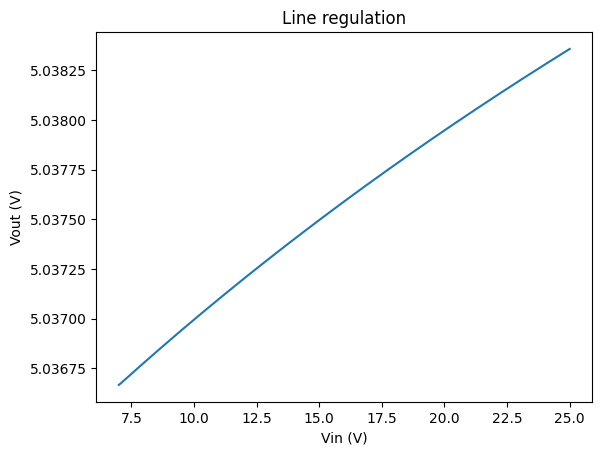

In [36]:
ng.cmd('dc v1 7 25 0.1')
vin = ng.vector('vin')
vout = ng.vector('out')
plt.plot(vin, vout)
plt.xlabel('Vin (V)')
plt.ylabel('Vout (V)')
plt.title('Line regulation')

In [37]:
delta = 1e3 * (vout[-1] - vout[0])
print('delta Vout = %.2f mV, ratio %.3f mV / V' % (delta, delta / (vin[-1] - vin[0])))

delta Vout = 1.69 mV, ratio 0.094 mV / V


### Load regulation

The datasheet says the typical $\Delta V_\mathrm{OUT}$ is 15mV when $I_\mathrm{OUT}$ changing from 5mA to 1.5A.
Our model is 7.6mV.

```
.dc rload 3 1000 1
```

Text(0.5, 1.0, 'Load regulation')

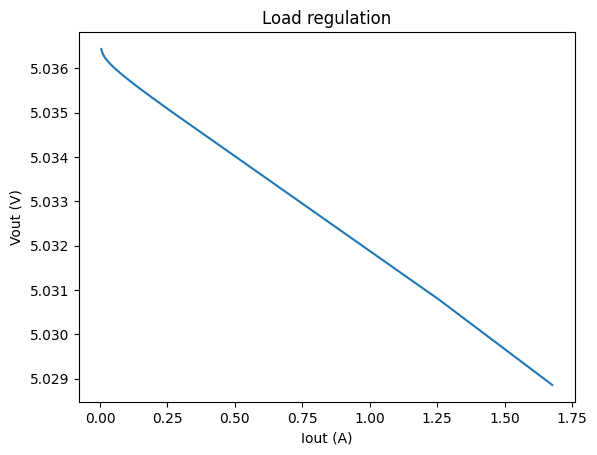

In [52]:
ng.cmd('dc rload 3 1000 1')
rload = ng.vector('res-sweep')
vout = ng.vector('out')
iout = vout / rload
plt.plot(iout, vout)
plt.xlabel('Iout (A)')
plt.ylabel('Vout (V)')
plt.title('Load regulation')

In [53]:
delta =  (vout[-1] - vout[0])
print('delta Vout = %.2f mV, Output resistance %.4f Ohm' % (1e3 * delta, delta / (iout[0] - iout[-1])))

delta Vout = 7.58 mV, Output resistance 0.0045 Ohm


### Startup circuit

* quiescent current is too large, almost 1mA is wasted.

```
.dc v1 0 10 0.1
```

Text(0, 0.5, 'Vout (V)')

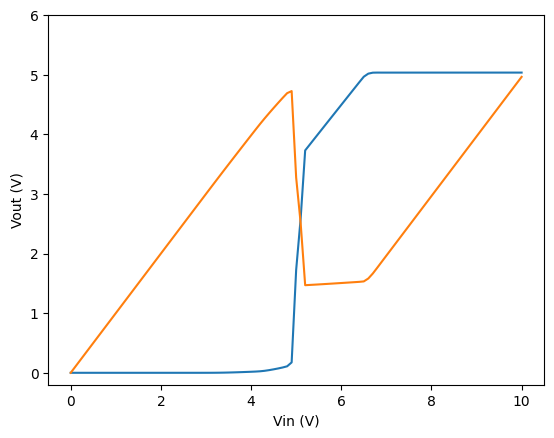

In [3]:
ng.cmd('dc v1 0 10 0.1')
vin = ng.vector('vin')
vout = ng.vector('out')
plt.plot(vin, vout)
plt.plot(vin, vin - vout)
plt.ylim(-0.2, 6)
plt.xlabel('Vin (V)')
plt.ylabel('Vout (V)')

In [33]:
for i in range(60, 71):
    print('Vin = %.2f V, Vout = %.3f V, Dropout %.2f V' % (vin[i], vout[i], vin[i] - vout[i]))

Vin = 6.00 V, Vout = 4.543 V, Dropout 1.46 V
Vin = 6.10 V, Vout = 4.638 V, Dropout 1.46 V
Vin = 6.20 V, Vout = 4.733 V, Dropout 1.47 V
Vin = 6.30 V, Vout = 4.827 V, Dropout 1.47 V
Vin = 6.40 V, Vout = 4.922 V, Dropout 1.48 V
Vin = 6.50 V, Vout = 5.000 V, Dropout 1.50 V
Vin = 6.60 V, Vout = 5.029 V, Dropout 1.57 V
Vin = 6.70 V, Vout = 5.037 V, Dropout 1.66 V
Vin = 6.80 V, Vout = 5.037 V, Dropout 1.76 V
Vin = 6.90 V, Vout = 5.037 V, Dropout 1.86 V
Vin = 7.00 V, Vout = 5.037 V, Dropout 1.96 V


### Feedback

In [10]:
ng.cmd('alter rload 1k')
op5mA = ng.operating_point()
ng.cmd('alter rload 5')
op1A = ng.operating_point()
ng.cmd('alter rload 100')

def diff_op(lhs, rhs):
  for k in sorted(lhs.keys()):
    old = lhs[k][0]
    new = rhs[k][0]
    if k[0] == '@' or '#' in k:
        if np.abs(new - old) < 1e-9:
            continue
        print('%15s %10.3f uA, %10.3f uA, delta %10.3f uA' %
              (k, old * 1e6, new * 1e6, (new - old) * 1e6))
    else:
        print('%15s %10.3f mV, %10.3f mV, delta %10.3f mV' %
              (k, old * 1e3, new * 1e3, (new - old)* 1e3))

diff_op(op5mA, op1A)

       @q10[ib]     17.756 uA,     17.712 uA, delta     -0.043 uA
       @q10[ic]   1478.852 uA,   1475.309 uA, delta     -3.542 uA
       @q10[ie]  -1496.607 uA,  -1493.022 uA, delta      3.586 uA
       @q11[ib]    -19.025 uA,    -16.310 uA, delta      2.715 uA
       @q11[ic]  -1271.141 uA,  -1099.414 uA, delta    171.727 uA
       @q11[ie]   1290.166 uA,   1115.724 uA, delta   -174.443 uA
       @q16[ib]     38.507 uA,    208.012 uA, delta    169.505 uA
       @q16[ic]   3192.112 uA,  17161.973 uA, delta  13969.861 uA
       @q16[ie]  -3230.619 uA, -17369.985 uA, delta -14139.367 uA
       @q17[ib]     33.088 uA,  11912.617 uA, delta  11879.529 uA
       @q17[ic]   2761.489 uA, 989954.471 uA, delta 987192.982 uA
       @q17[ie]  -2794.577 uA, -1001867.088 uA, delta -999072.511 uA
        @q1[ib]     17.647 uA,     17.603 uA, delta     -0.044 uA
        @q1[ic]   1420.520 uA,   1416.993 uA, delta     -3.527 uA
        @q1[ie]  -1438.167 uA,  -1434.596 uA, delta      3.571 uA
       

### Fixing tempco

0.33500589559324734


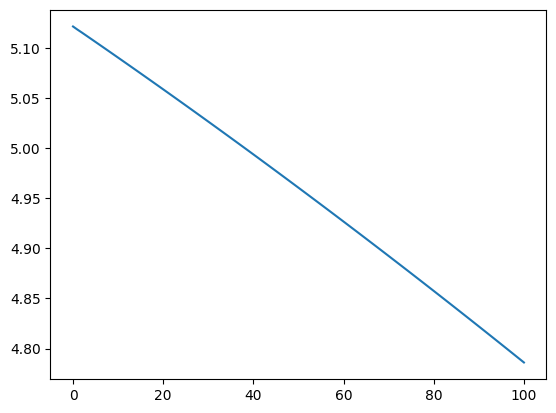

In [41]:
ng.cmd('dc temp 0 100 1')
temp = ng.vector('temp-sweep')
vout = ng.vector('out')
plt.plot(temp, vout)
print(max(vout) - min(vout))

Changing $R_2$

R2 = 31 k, Vout@27C = 6.579 V, delta Vout =  167.9 mV
R2 = 30 k, Vout@27C = 6.433 V, delta Vout =  120.4 mV
R2 = 29 k, Vout@27C = 6.289 V, delta Vout =   73.1 mV
R2 = 28 k, Vout@27C = 6.145 V, delta Vout =   26.4 mV
R2 = 27 k, Vout@27C = 6.002 V, delta Vout =  -20.1 mV
R2 = 26 k, Vout@27C = 5.861 V, delta Vout =  -66.2 mV
R2 = 25 k, Vout@27C = 5.720 V, delta Vout = -112.0 mV
R2 = 24 k, Vout@27C = 5.581 V, delta Vout = -157.4 mV
R2 = 23 k, Vout@27C = 5.443 V, delta Vout = -202.4 mV
R2 = 22 k, Vout@27C = 5.306 V, delta Vout = -247.1 mV
R2 = 21 k, Vout@27C = 5.170 V, delta Vout = -291.2 mV
R2 = 20 k, Vout@27C = 5.036 V, delta Vout = -335.0 mV


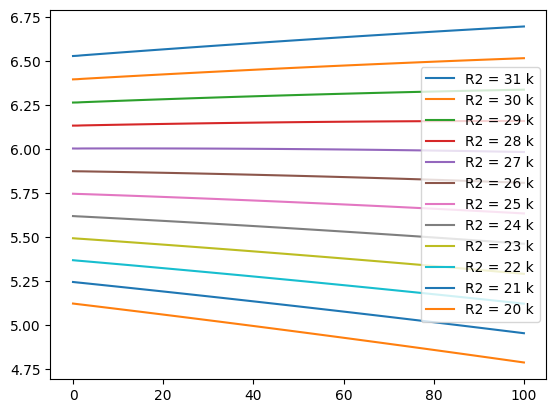

In [42]:
for r2 in range(31, 19, -1):
  ng.cmd('alter r2 %d' % (r2*1000))
  ng.cmd('dc temp 0 100 1')
  temp = ng.vector('temp-sweep')
  vout = ng.vector('out')
  plt.plot(temp, vout, label = 'R2 = %d k' % r2)
  print('R2 = %d k, Vout@27C = %.3f V, delta Vout = %6.1f mV' % (r2, vout[27], 1e3*(vout[-1] - vout[0])))
plt.legend()

In [43]:
# R2 was 20k
r2 = 27
ng.cmd('alter r2 %d' % (r2*1000))
print_op()

       out =  6002.43 mV
      q10e =  5309.48 mV
      q11b =  6736.01 mV
      q12b =  5514.02 mV
      q12c =  9631.36 mV
      q12e =  4849.91 mV
      q13b =  2387.65 mV
      q14b =   373.07 mV
      q17b =  6736.82 mV
      q17e =  6019.68 mV
       q1b =   692.90 mV
       q1c =  1314.85 mV
       q3b =   593.50 mV
       q4b =  1205.16 mV
       q5e =  3484.24 mV
       q6e =  4178.00 mV
       q8b =  9064.39 mV
       q8e =  9780.98 mV
       q9c =  7446.98 mV
       q9e =  9780.26 mV
        r3 =    84.28 mV
       ref =  4800.19 mV
 v1#branch = -66272.01 uA
       vin = 10000.00 mV


0.020429764616625157


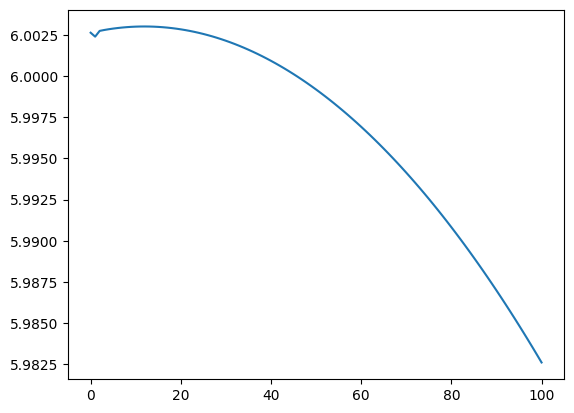

In [44]:
ng.cmd('dc temp 0 100 1')
temp = ng.vector('temp-sweep')
vout = ng.vector('out')
plt.plot(temp, vout)
print(max(vout) - min(vout))

Bring back the output voltage by adjusting $R_{20}$

0.01647117642314555


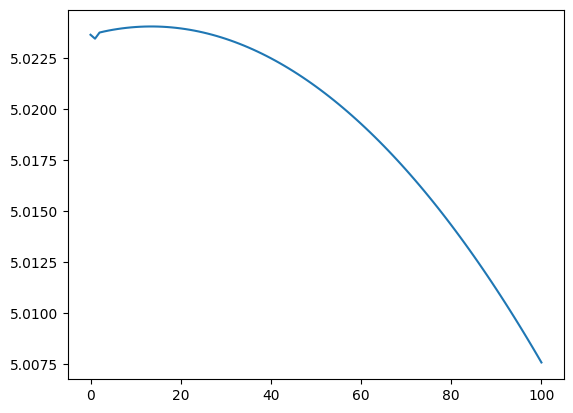

In [45]:
# R20 was 1.2k
ng.cmd('alter r20 230')
ng.cmd('dc temp 0 100 1')
temp = ng.vector('temp-sweep')
vout = ng.vector('out')
plt.plot(temp, vout)
print(max(vout) - min(vout))

Changing $V_\mathrm{BE}$?

0.21101409673965943
0.09132583609916978


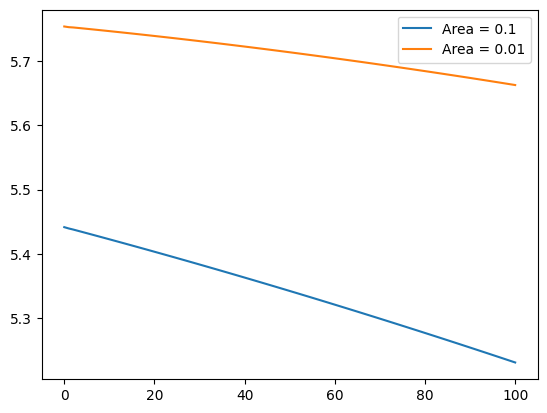

In [17]:
ng.circ('''
  V1    vin  0   10V
  Rload out  0   100

  * Bandgap reference
  R1  q5e  q1c      1k
  Q1  q1c  q1b 0    NPN
  Q7  q5e  q1c q1b  NPN
  R10 q1b  0        6k
  Q2  q4b  q1b r3   NPN
  R3  r3   0        1k
  R2  q5e  q4b      20k

  * Error amplifier
  Q4  q11b q4b  q3b  NPN 0.1
  Q3  q11b q3b  0    NPN 0.1
  R14 q3b  0         6k
  Q11 0    q11b q9c  PNP
  R16 q9c  q11b      6k

  * Current mirror
  R8  vin  q8e 100
  R9  vin  q9e 100
  Q8  q8b  q8b q8e  PNP
  Q9  q9c  q8b q9e  PNP

  * Feedback
  Q10 q8b  out q10e NPN
  Q5  q10e q6e q5e  NPN 0.1
  Q6  out  ref q6e  NPN 0.1
  R15 q6e  q5e      6k
  R19 ref  0        5k
  R20 out  ref      1.25k

  * Output
  Q16 vin  q9c  q17b NPN
  Q17 vin  q17b q17e NPN 10
  R11 q17e out       0.3
  R17 q17b out       200

  * Start-up
  R4  vin  q12b      100k
  D1  0    q12b      DZ
  R18 vin  q12c      500
  Q12 q12c q12b q12e NPN
  R5  q12e q13b      3.3k
  R6  q13b q14b      2.7k
  R7  q14b 0         500
  Q13 q8b  q13b q5e  NPN
  
  * .options savecurrents
.MODEL NPN NPN( IS=5f BF=80  VAF=100 CJC=1P CJE=2P )
.MODEL PNP PNP( IS=2f BF=60  VAF=50  CJC=1P CJE=2P )
.MODEL DZ D(BV=5.6)
''')


ng.cmd('dc temp 0 100 1')
temp = ng.vector('temp-sweep')
vout = ng.vector('out')
plt.plot(temp, vout, label='Area = 0.1')
print(max(vout) - min(vout))

ng.cmd('alter @q3[area] = 0.01')
ng.cmd('alter @q4[area] = 0.01')
ng.cmd('alter @q5[area] = 0.01')
ng.cmd('alter @q6[area] = 0.01')

# print_op()
ng.cmd('dc temp 0 100 1')
temp = ng.vector('temp-sweep')
vout = ng.vector('out')
plt.plot(temp, vout, label='Area = 0.01')
print(max(vout) - min(vout))
plt.legend()

## LM7805

### SPICE model

https://github.com/kafana/ltspice-misc/blob/master/models/regulators.lib

In [2]:
ng.circ('''
  V1 vcc 0 10
  Rload out 0 100
  X1 vcc 0 out LM7805
  .options savecurrents

.SUBCKT LM7805  Vin    GND    Out
* In GND Out
Q1          q1c   fb    q1e   Q_NPN 0.1
Q2          q1e   q2b   q3b   Q_NPN 0.1
Q3          q4b   q3b   GND   Q_NPN 0.1
C2          q3b   q4b         4p
R2          q1e   q2b         1.9K
R3          q2b   q4b         26
R4          q3b   GND         1.2K
R5          q5b   GND         12.1K
R6          q5e   GND         1K
R7          q6e   q7b         16.5K
R8          q9e   GND         4K
Q4          q6e   q4b   q5b   Q_NPN 0.1
Q5          q7b   q5b   q5e   Q_NPN 0.1
C1          q7b   q10b        20P
Q6          q16b  fb    q6e   Q_NPN 0.1
Q7          q10b  q7b   q8b   Q_NPN 0.1
Q8          q10b  q8b   GND   Q_NPN 0.1
Dq9         q8b   q9e  	      D_D 
Q10         GND   q10b  q10e  Q_PNP 0.1
R9          q10e  q10b        4K
R10         q15b  q10e        850
Q11         q11c  q11c  Vin   Q_PNP 0.1
Q11o        q15b  q11c  Vin   Q_PNP 0.1
Q12         Vin   q12b  q17b  Q_NPN 0.1
DZ1         GND   q12b        D_5V6
R1          Vin   q12b        80K
Q13         q15b  q13b  GND   Q_NPN 0.1
R13         q13b  GND         830
R11         q18b  q13b        4.97K
Q14         q15b  q14b  q14e  Q_NPN 1 
R14         q14b  q16e        380
R15         q14b  q16b        1.62K
R19         q14e  Out         100
DZ2         q14b  dz2k        D_5V1 
R17         Vin   dz2k        16K
Q15         Vin   q15b  q16b  Q_NPN 1
Q16         Vin   q16b  q16e  Q_NPN 10
R16         q16e  Out         250m
Q17         q11c  q17b  q1c   Q_NPN 0.1
Q18         q11c  q18b  q18e  Q_NPN 0.1
R12         q17b  q18b        7K
R18         q18e  q1e         500
R20         Out   fb          640
R21         fb    GND         2.67K

.MODEL D_5V1 D( IS=10F N=1.16 BV=5.1 IBV=0.5M CJ0 = 1P TT = 10p )
.MODEL D_5V6 D( IS=10F N=1.16 BV=5.6 IBV=5U CJ0 = 1P TT = 10p )
.MODEL Q_NPN NPN( IS=10F NF=1.16 NR=1.16 BF=80 CJC=1P CJE=2P TF=10P TR=1N )
.MODEL Q_PNP PNP( IS=10F NF=1.16 NR=1.16 BF=80 CJC=1P CJE=2P TF=10P TR=1N )
.MODEL D_D D( IS=1F N=1.16 CJ0 = 1P TT = 10p )

.ENDS LM7805
''')

x = print_op(1, 1)

@c.x1.c1[i] =     0.00 uA
@c.x1.c2[i] =     0.00 uA
@d.x1.dq9[id] =    18.12 uA
@d.x1.dz1[id] =   -49.22 uA
@d.x1.dz2[id] =    -0.06 uA
@q.x1.q10[ib] =   -14.86 uA
@q.x1.q10[ic] = -1188.51 uA
@q.x1.q10[ie] =  1203.37 uA
@q.x1.q11[ib] =   -17.84 uA
@q.x1.q11[ic] = -1426.88 uA
@q.x1.q11[ie] =  1444.72 uA
@q.x1.q11o[ib] =   -17.84 uA
@q.x1.q11o[ic] = -1426.88 uA
@q.x1.q11o[ie] =  1444.72 uA
@q.x1.q12[ib] =     4.92 uA
@q.x1.q12[ic] =   393.64 uA
@q.x1.q12[ie] =  -398.56 uA
@q.x1.q13[ib] =    -0.00 uA
@q.x1.q13[ic] =     0.00 uA
@q.x1.q13[ie] =    -0.00 uA
@q.x1.q14[ib] =    -0.00 uA
@q.x1.q14[ic] =     0.00 uA
@q.x1.q14[ie] =    -0.00 uA
@q.x1.q15[ib] =    14.96 uA
@q.x1.q15[ic] =  1197.17 uA
@q.x1.q15[ie] = -1212.13 uA
@q.x1.q16[ib] =   631.50 uA
@q.x1.q16[ic] = 50520.31 uA
@q.x1.q16[ie] = -51151.81 uA
@q.x1.q17[ib] =    18.28 uA
@q.x1.q17[ic] =  1462.56 uA
@q.x1.q17[ie] = -1480.84 uA
@q.x1.q18[ib] =    -0.00 uA
@q.x1.q18[ic] =     0.00 uA
@q.x1.q18[ie] =    -0.00 uA
@q.x1.q1[ib] =    18

### Quiescent current

In [16]:
ng.cmd('alter rload 1k')
print_op()

       out =  5002.84 mV
 v1#branch = -10036.89 uA
       vcc = 10000.00 mV
   x1.dz2k =  9997.95 mV
     x1.fb =  4024.83 mV
   x1.q10b =  4454.26 mV
   x1.q10e =  5288.64 mV
   x1.q11c =  9160.31 mV
   x1.q12b =  5668.61 mV
   x1.q13b =   315.63 mV
   x1.q14b =  5146.06 mV
   x1.q14e =  5002.84 mV
   x1.q15b =  6494.95 mV
   x1.q16b =  5749.49 mV
   x1.q16e =  5004.47 mV
   x1.q17b =  4867.57 mV
   x1.q18b =  2205.62 mV
   x1.q18e =  3184.02 mV
    x1.q1c =  4027.14 mV
    x1.q1e =  3184.02 mV
    x1.q2b =  1640.19 mV
    x1.q3b =   822.44 mV
    x1.q4b =  1619.29 mV
    x1.q5b =   869.10 mV
    x1.q5e =   107.40 mV
    x1.q6e =  3247.87 mV
    x1.q7b =  1493.46 mV
    x1.q8b =   781.20 mV
    x1.q9e =    72.50 mV


In [17]:
print(10.03689 - 5.00284)

5.03405


### Input

Vin = 6.00V, Vout = 4.4677 V
Vin = 6.10V, Vout = 4.5664 V
Vin = 6.20V, Vout = 4.6651 V
Vin = 6.30V, Vout = 4.7637 V
Vin = 6.40V, Vout = 4.8619 V
Vin = 6.50V, Vout = 4.9580 V
Vin = 6.60V, Vout = 5.0014 V
Vin = 6.70V, Vout = 5.0029 V
Vin = 6.80V, Vout = 5.0029 V
Vin = 6.90V, Vout = 5.0028 V
Vin = 7.00V, Vout = 5.0028 V


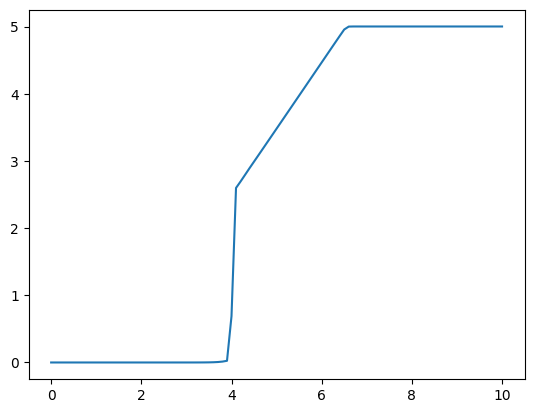

In [4]:
ng.cmd('dc v1 0 10 0.1')
Vin = ng.vector('vcc')
Vout = ng.vector('out')
plt.plot(Vin, Vout)
for i in range(60, 71):
    print('Vin = %.2fV, Vout = %.4f V' % (Vin[i], Vout[i]))

### Line regulation

0.01970506928827831


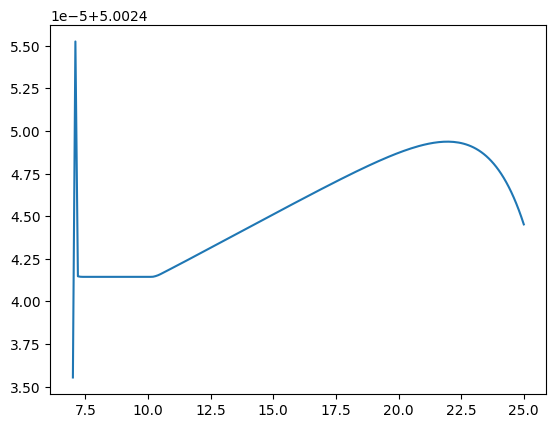

In [32]:
ng.cmd('alter rload 10')
ng.cmd('dc v1 7.0 25 0.1')
Vin = ng.vector('vcc')
Vout = ng.vector('out')
print(1e3*(max(Vout) - min(Vout)))
plt.plot(Vin, Vout)

0.9663296921011977


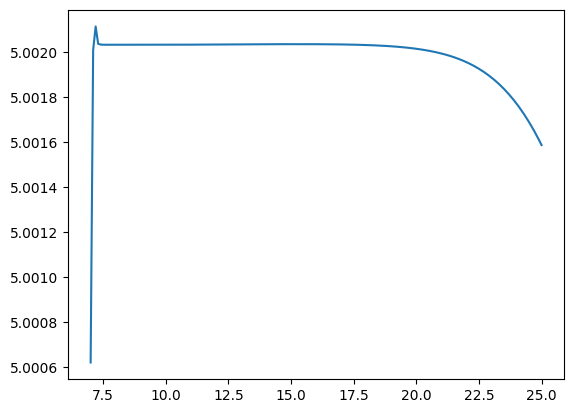

In [29]:
ng.cmd('alter rload 5')
ng.cmd('dc v1 7.0 25 0.1')
Vin = ng.vector('vcc')
Vout = ng.vector('out')
print(1e3*(Vout[-1]-Vout[0]))
plt.plot(Vin, Vout)

### Load regulation


delta Vout = 1.39 mV, in 0.0008 Ohm


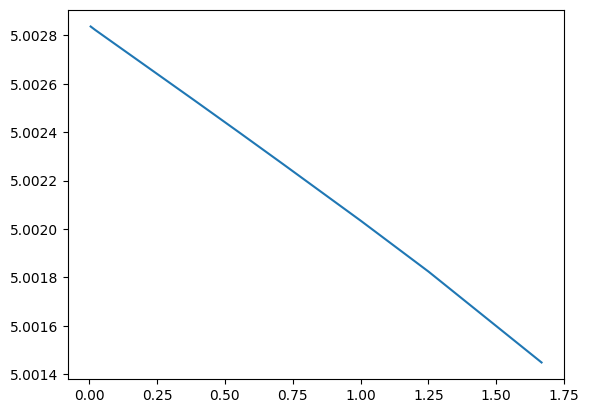

In [8]:
ng.cmd('dc rload 3 1000 1')
rload = ng.vector('res-sweep')
vout = ng.vector('out')
iout = vout / rload
plt.plot(iout, vout)

delta =  (vout[-1] - vout[0])
print('delta Vout = %.2f mV, in %.4f Ohm' % (1e3 * delta, delta / (iout[0] - iout[-1])))

### Short-circuit

0.1716012232593159


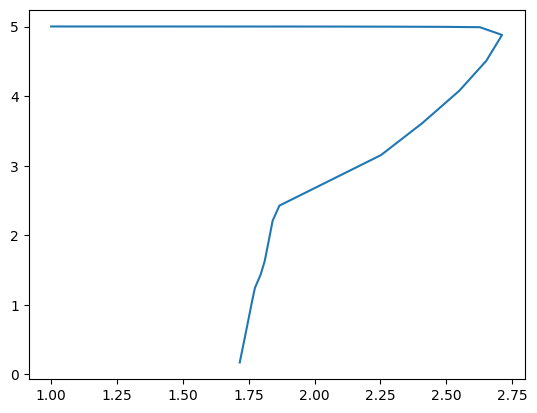

In [35]:
ng.cmd('dc rload 0.1 5 0.1')
rload = ng.vector('res-sweep')
vout = ng.vector('out')
iout = vout / rload
plt.plot(iout, vout)

delta =  (vout[-1] - vout[0])
print(vout[0])

### Tempco

0.09759713480243715
0.7933333333333333
0.976


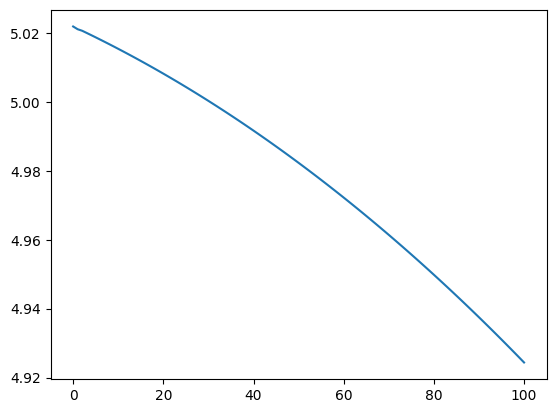

In [10]:
ng.cmd('dc temp 0 100 1')
plt.plot(ng.vector('temp-sweep'), ng.vector('out'))
print(max(ng.vector('out')) - min(ng.vector('out')))
print(119/150)
print(97.6 / 100)